# *Including wildfires in a landscape evolution model*
### --Nishani Moragoda, Kevin Pierce, Laurent Roberge--

<img src="files/image.jpg" width="600" height="600">

## Introduction

Wildfires are a major form of disturbance occurring in forested landscapes. Recent studies have shown that the areas burned by wildfires have increased in the recent past and this trend is expected to continue over the 21st century, particularly due to to the warming climate. Wildfires alter the hydrologic and geomorphic processes in the burned landscape, with potential implications for water quality and aquatic ecosystems. 

Wildfire-burnt areas are more prone to soil erosion due to the loss of protective ground cover and vegetation that leaves soil exposed for erosion by subsequent rainfall. In addition, increased rates of overland flow resulting from a combination of surface sealing, reduced infiltration through the development of hydrophobic soil layers, and reduced surface roughness, also contribute to enhanced susceptibility to erosion. This can increase the delivery of sediment, along with particulate nutrients and contaminants, into river channels. In some instances, a large proportion of the total long-term sediment supply to rivers can be linked to post-fire erosion. This may negatively impact water quality, decrease reservoir storage capacities, and interfere with water treatment and supply mechanisms. Potential impacts to aquatic ecosystems range from destruction of fish habitats to alterations of channel flow regime. Therefore, understanding how changing frequency, extent, and magnitude of wildfires will affect the fluvial sediment fluxes is vitally important. 

In this lab, we will explore the sediment flux response to stochastic wildfires that increase soil erodibility, and its impacts on the evolution of the landscape.


## Model information

### Fastscape Eroder

The **Fastscape Eroder** is an efficient fluvial incision model that uses the Braun-Willett approach to solving the stream power equation:

\begin{equation}
\frac{d z}{d t} = -KA^{m}S^{n} + U 
\end{equation}

Where $dz/dt$ is the rate of change of elevation, $K$ is the erodibility coefficient, $A$ is the upstream drainage area, $S$ is channel slope, and $m$ and $n$ are empirical exponents. $U$ is uplift.

This stream power equation is a typical equation used to generate fluvial networks in landscape evolution models. Solving this equation for every point in the landscape generates a steadily eroding bedrock surface. Although this equation is efficient to compute, it does not allow for deposition of sediment, which means that all sediment eroded from the landscape is immediately transported through the watershed outlet.

More details about the **Fastscape Eroder** component in Landlab can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/stream_power.html 

And Braun & Willett’s 2013 paper is here: 

Braun, J., Willett, S. (2013). A very efficient O(n), implicit and parallel method to solve the stream power equation governing fluvial incision and landscape evolution. Geomorphology 180-181(C), 170-179. https://dx.doi.org/10.1016/j.geomorph.2012.10.008 

### SPACE (Stream Power with Alluvium Conservation and Entrainment): 

The **SPACE** component is another model that simulates fluvial processes. Although it is also built on the stream power equation, in contrast to the **Fastscape Eroder** it not only tracks erosion of bedrock, but also entrainment and deposition of sediment on top of the bedrock. The downside is that it takes much longer to solve the more complicated algorithm. Because of this, we will first run the **Fastscape Eroder** to imprint a fluvial network into the grid and then we will switch over to the **SPACE** model to track sediment fluxes as fires affect the landscape. 

More details about the **SPACE** component in Landlab can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/space.html 

And the Shobe et al. (2017) paper is here: 

Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 

### Other components 

We also need the **FlowAccumulator** and **DepressionFinderAndRouter** components. These calculate the routing of flow across the grid and deal depressions/lakes in the landscape. More info can be found here:  

https://landlab.readthedocs.io/en/master/reference/components/flow_accum.html 

https://landlab.readthedocs.io/en/master/reference/components/flow_routing.html 

Finally, we have added three modules that are not Landlab components: 

The **Burner** generates stochastic wildfires that burn parts of the landscape and the **Erodibility Stepper** changes the soil erodibility a fire has occurred. The **Plotter** forms a visualization of the landscape with burned areas. These will be described in more detail when they show up in the notebook.

### Import statements

First, we import the necessary libraries and components. 

In [106]:
import os
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt 
from firemodel import *
from plotter import fireplot
from create_network import create_network_from_raster
from landlab.io.netcdf import (write_netcdf, read_netcdf)
from landlab import (RasterModelGrid, imshow_grid)
from landlab.plot import graph
from landlab.components import (DepressionFinderAndRouter,
                                FastscapeEroder,
                                FlowAccumulator,
                                Space,
                                ChannelProfiler)
%matplotlib inline

# Here figures are made larger and matplotlib warnings are suppressed for presentation purposes
plt.rcParams['figure.figsize'] = [10, 10] 
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from IPython.display import clear_output

# temporary.. autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set some parameters

Here, we set the parameters we'll need for the rest of the lab.

There will be an opportunity to change the burn frequency and explore its effects later.

In [107]:
# Saving outputs
printit = True        # be verbose with printing output our not?
saveit=True             # save outputs to a directory or not? 
save_dir = './simul/' # directory in which to save outputs
# if save directory does not exist and you are to save, make save_dir.
if saveit:
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

# Grid parameters
#dx = 100              # distance between each node (m) 
#np.random.seed(5000) #5000  # reproducible random seed to add initial topographic roughness
#grid_dim = (50,50)    # number of nodes along each axis (x,y)

# Grid parameters
#dx = 50              # distance between each node (m) 
#np.random.seed(5000) #5000  # reproducible random seed to add initial topographic roughness
#grid_dim = (100,100)    # number of nodes along each axis (x,y)

dx = 25              # distance between each node (m) 
np.random.seed(5000) #5000  # reproducible random seed to add initial topographic roughness
grid_dim = (200,200)    # number of nodes along each axis (x,y)

# Timesteps, runtime, and uplift rate for Fastscape imprint time window
dt_fs = 1000                # timestep in years
runtime_fs = 2000000        # length of the simulation in years
ndt_fs = runtime_fs//dt_fs  # number of timesteps
U_fs = 0.002                # Uplift rate in m/yr

# Timesteps, runtime, and uplift rate for SPACE wildfire simulation time window
dt_sp = 1                   # timestep in years
runtime_sp = 1000           # length of the simulation in years
#runtime_sp = 250         # length of the simulation in years
ndt_sp = runtime_sp//dt_sp  # number of timesteps
U_sp = 0.002                # Uplift rate in m/yr

# Fastscape Eroder parameters
K_sp=0.00001          # erodibility coefficient
m_sp=0.5              # Drainage area exponent
n_sp=1                # Slope exponent

# SPACE parameters (we will use the same K, m, and n as above)
K_sed0 = 0.00001        # Baseline soil erodiblity
K_br = 0.00001          # Bedrock erodibility coefficient
F_f = 0                 # The fraction of fine sediment that becomes suspended as washload
phi = 0                 # Sediment porosity
H_star = 1.             # Bedrock roughness scale
v_s = 0.001             # Settling length scale for entrained sediment to travel before depositing
sp_crit_sed = 0         # Critical stream power threshold required to entrain sediment
sp_crit_br = 0          # Critical stream power threshold required to erode bedrock

# Erodibility stepper
decay_time = dt_sp*10     # time it takes the erodibility perturbutions to decay

# Burner
R_fire_mean = grid_dim[0]*dx/10    # Mean fire radius in m. 1/20 the size of the grid.
fire_freq = 1/(10*dt_sp)          # Fire frequency in #/yr. This is one every 10
K_sed_boost = 5*K_sed0           # The increase in sediment erodibility due to fire

### Instantiate the model grid
Here, we instantiate a 50x50 node model grid (5000x5000 m). The bottom left corner is the watershed outlet, so we set it to an open boundary condition to allow flux out. All other boundary nodes are closed. The initial topography is tilted downwards from the upper right towards the outlet and has random roughness to make it look more natural.

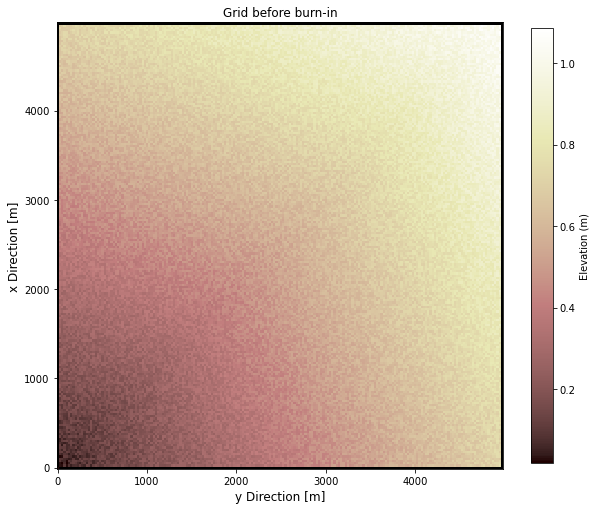

In [108]:
# Instantiate the raster model grid
mg = RasterModelGrid(grid_dim, xy_spacing=dx)
_ = mg.add_zeros('topographic__elevation', at='node')

# Add tilt and seeded random noise to the topography
mg.at_node['topographic__elevation'] += (mg.node_y / 10000. + 
                                         mg.node_x / 10000. + np.random.rand(len(mg.node_y))/10 )
mg.at_node['topographic__elevation'] += np.heaviside(mg.node_y-mg.node_x,1)*(mg.node_y-mg.node_x)/30000
mg.at_node['topographic__elevation'] += -np.heaviside(-mg.node_y+mg.node_x,1)*(mg.node_y-mg.node_x)/30000

# Set the boundary conditions
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                        left_is_closed=True,
                                        right_is_closed=True,
                                        top_is_closed=True)
mg.set_watershed_boundary_condition_outlet_id(0, mg.at_node['topographic__elevation'], -9999.)

# Plot the initial topographic conditions
mg.imshow('node',
          'topographic__elevation',
          shrink=0.80,  # shrink controls size of colorbar
          colorbar_label='Elevation (m)'
         )
plt.title('Grid before burn-in',fontsize=12)
plt.xlabel("y Direction [m]",fontsize=12)
plt.ylabel("x Direction [m]",fontsize=12)

plt.show()

### Instantiate the model components for imprinting the initial landscape

Here we instantiate the **Fastscape Eroder**, **Flow Router**, and **Depression Finder**. 

In [109]:
#Instantiate the fastscape eroder, flow router, and depression finder
fr = FlowAccumulator(mg, flow_director='D8')
df = DepressionFinderAndRouter(mg)
fsc = FastscapeEroder(
    mg,
    K_sp=K_sp,
    m_sp=m_sp,
    n_sp=n_sp)

### Imprint an initial drainage network
We use the **Fastscape eroder** to "burn in" (no pun intended...) an initial drainage network since the algorithm is much faster than **SPACE**. The algorithm calculates quickly across the grid and is also stable at long timesteps. We are able to use 1000-year timesteps here, compared to a maximum of about 10 years for **SPACE**.

We iterate the **Fastscape eroder** through a time loop to evolve the landscape to a steady state before adding soil to set up the conditions for the **SPACE** model.

Text(0, 0.5, 'x Direction [m]')

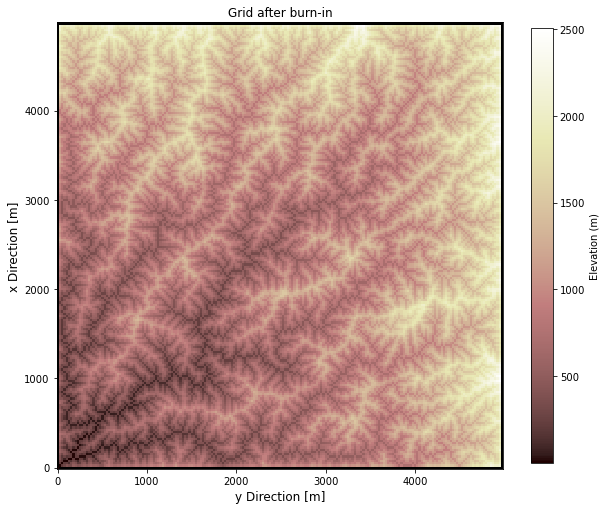

In [110]:
# Create empty array to fill with sediment flux and time values 
sedflux = np.zeros(ndt_fs)
t_sedflux = np.zeros(ndt_fs)

# Time loop running the fastscape eroder
for it in range(ndt_fs):
    elev_1 = mg.at_node['topographic__elevation'][mg.core_nodes]
    fr.run_one_step()
    df.map_depressions()
    fsc.run_one_step(dt=dt_fs)
    elev_2 = mg.at_node['topographic__elevation'][mg.core_nodes]
    
    mg.at_node['topographic__elevation'][mg.core_nodes] += U_fs*dt_fs # Uplift
    sedflux[it] = sum(elev_1-elev_2)*(dx*dx)/dt_fs
    t_sedflux[it] = it*dt_fs
    
# Add soil to the drainage network (for SPACE)
_ = mg.add_zeros('soil__depth', at='node', dtype=float) 
mg.at_node['soil__depth'] += 0.5
mg.at_node['topographic__elevation'] += mg.at_node['soil__depth']

# Plot the burned in topographic conditions
mg.imshow('node',
          'topographic__elevation',
          shrink=0.80,  # shrink controls size of colorbar
          colorbar_label='Elevation (m)'
         )
plt.title('Grid after burn-in',fontsize=12)
plt.xlabel("y Direction [m]",fontsize=12)
plt.ylabel("x Direction [m]",fontsize=12)

### Plot sediment flux at the outlet
At steady state, the rate of erosion throughout the landscape matches the rate of uplift, so the sediment flux at the outlet of the watershed is stable through time. Note how sediment flux increases early on when the landscape is adjusting and then since becomes steady after about 1.5 million years. 

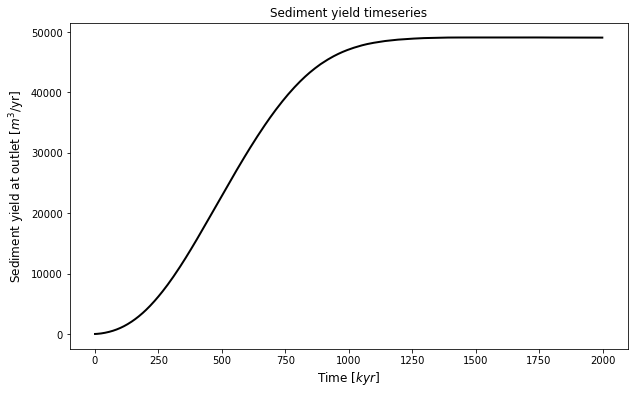

In [111]:
# Plot sediment flux timeseries
plt.plot(t_sedflux/1000, sedflux, color='black', lw=2)
plt.xlabel('Time [$kyr$]',fontsize=12)
plt.ylabel('Sediment yield at outlet [$m^3$/yr]', fontsize=12)
plt.title('Sediment yield timeseries', fontsize=12)
fig = plt.gcf()
fig.set_size_inches(10,6)
fig.patch.set_facecolor('white')

plt.show()

### Instantiate the components for exploring the effects of fire
Here, we instantiate **SPACE**, **Erodibility Stepper**, and **Burner**. We also add a layer of soil to the grid. Remember that the **Fastscape Eroder** acts only on bedrock, but **SPACE** acts on sediment as well. The **Burner** will generate a fire, then the **Erodibility Stepper** will increase the erodibility of the soil in the burned area and slowly return the erodibility back to “normal”.  

In [112]:
# Instantiate the SPACE component
K_sed = np.ones(mg.shape)*K_sed0 # the initial soil erodibility per node
ha = Space(
    mg,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    m_sp=m_sp,
    n_sp = n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br)

# Instantiate the erodibility stepper
es = ErodibilityStepper(decay_time=decay_time, K_sed0=K_sed0)

# Instantiate the burner
burner = Burner(fire_freq=fire_freq,
                R_fire_mean=R_fire_mean,
                K_sed_boost=K_sed_boost,
                dt=dt_sp,dx=dx)

### Run the landscape evolution model
Now we iterate the three newly instantiated models through a time loop. This time around, since the erodibility is changing through time due to fires, what do you think the sediment flux timeseries will look like? 

In [ ]:
start_time = time.time() # for the purposes of tracking the runtime of the simulation loop

sedflux = np.empty(shape=ndt_sp) # empty array to be filled with values of the sediment flux.
t_sedflux = np.empty(shape=ndt_sp) # empty array to be filled with times at which the flux is recorded.

for it in range(ndt_sp): # iterate through timesteps
    fr.run_one_step()           # accumulate the flow
    df.map_depressions()        # find landscape depressions (which do not erode)
    ha.run_one_step(dt=dt_sp)   # step the transport model
    es.stepper(ha,dt=dt_sp)     # decay the erodibility back toward baseline from the former timestep
    burner.fire(ha,mg,it*dt_sp)          # light any fires (increase erodibility)
    mg.at_node['bedrock__elevation'][mg.core_nodes] += U_sp*dt_sp # incorporate uplift
    sedflux[it] = mg.at_node['sediment__flux'][grid_dim[0]+1] # sediment flux at the outlet node (1,1).
    t_sedflux[it] = it*dt_sp # time at which the sediment flux was recorded
    if (it*dt_sp % 10 == 0) and printit: # if a decade has gone by, then print
        clear_output(wait=True) # jupyter functionality to print over previous output
        print("--", it*dt_sp, "years simulated -- %s seconds runtime --" % round((time.time() - start_time), 1))
        if saveit: # if saveit==True, then save the topographic grid and the erodibility matrix
            filename = save_dir + 'simul_%05d.nc'%it # name of file to save the elevation grid
            filename_npy = save_dir + 'simul_%05d'%it # name of file to save the erodibility matrix
            write_netcdf(filename, 
                         mg, 
                         format="NETCDF3_64BIT", # save the grid as a netcdf file
                        ) 
            np.save(filename_npy, K_sed) # the erodibility matrix is saved as a .npy file.

-- 10 years simulated -- 56.2 seconds runtime --


### Compare the sediment transport rate at the basin outlet to the  wildfire occurrence
Now we visualize the sediment transport rate at the basin outlet and compare that to the wildfire size and timing in the basin.

Text(0.5, 1.0, 'Fire magnitudes through time')

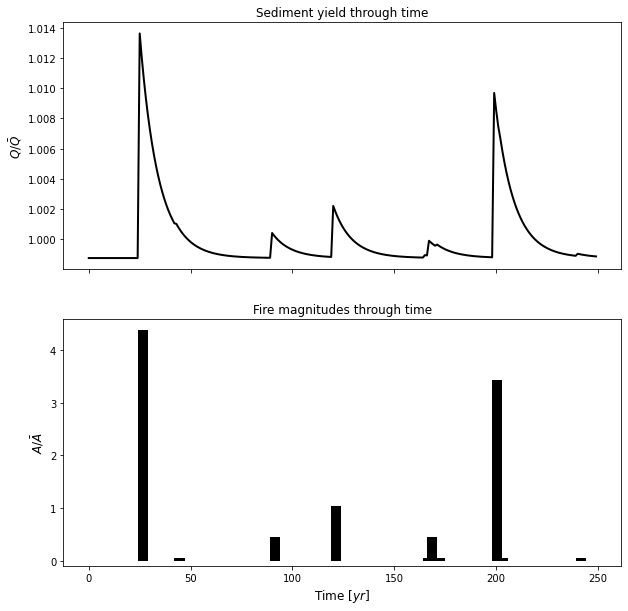

In [88]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True) # initialize a two-panel plot
# the upper panel is the flux scaled against its mean versus time
ax1.plot(t_sedflux, sedflux/np.mean(sedflux), lw=2, color='black') 
# the lower panel is a bar chart indicating the areas of fires on the y axis and their timing on the x axis
# notice that the burner object records the times when fires occurred and how large they were.
ax2.bar(burner.fireTimes,burner.fireSizes/np.mean(burner.fireSizes), width=5, align='edge', lw=2, color='black')

plt.xlabel("Time [$yr$]",fontsize=12)
ax1.set_ylabel(r"$Q/\bar{Q}$",fontsize=12)
ax2.set_ylabel(r"$A/\bar{A}$",fontsize=12)
ax2.set_ylim(-0.1)

ax1.set_title('Sediment yield through time',fontsize=12)
ax2.set_title('Fire magnitudes through time',fontsize=12)

### Visualize fire occurrence and landscape evolution
Here we use a custom plotting function to view fires occuring as the landscape evolves. This function simply plots the landscape as before, but with a grey colormap where the landscape is burned.

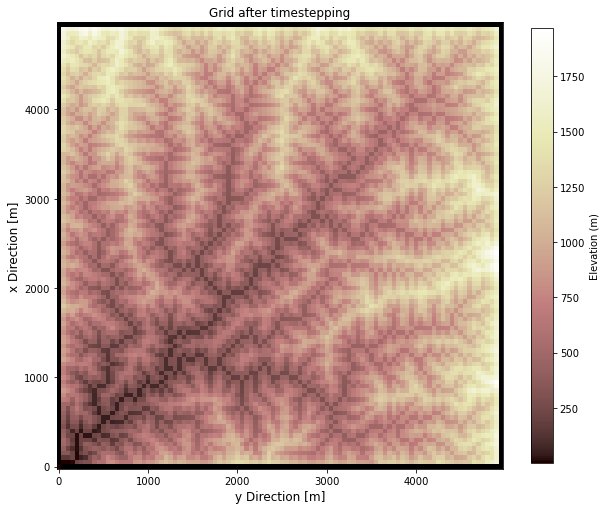

In [89]:
# Topography after evolving the landscape
mg.imshow('node','topographic__elevation', shrink=0.8, colorbar_label='Elevation (m)')
plt.title('Grid after timestepping',fontsize=12)
plt.xlabel("y Direction [m]",fontsize=12)
plt.ylabel("x Direction [m]",fontsize=12)
plt.show()

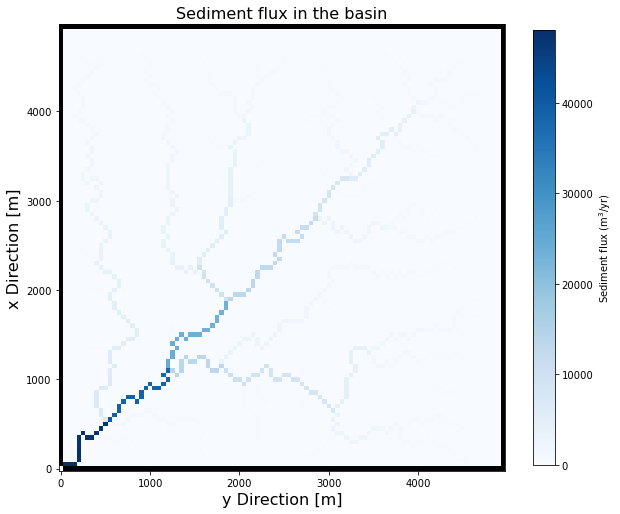

In [90]:
# Map of sediment flux
fig = plt.figure()
plot = plt.subplot()
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='Blues',shrink=0.8)
plt.title('Sediment flux in the basin',fontsize=16)
plt.xlabel("y Direction [m]",fontsize=16)
plt.ylabel("x Direction [m]",fontsize=16)
plt.show()

### Develop a movie of the landscape and fire evolution

In [92]:
dx

50

In [96]:
base = './simul/'
save = './imgs/'
files = sorted(os.listdir(base))
ks_files = [f for f in files if f[-3:] == 'npy']
mg_files = [f for f in files if f[-2:] == 'nc']

# find max and min elevations across all datasets

for f1,f2 in zip(ks_files,mg_files):
    f1p=base+f1
    f2=base+f2
    K_sed = np.load(f1p)
    mg = read_netcdf(f2)
    mg.at_node['flow__link_to_receiver_node']= [int(x) for x in mg.at_node['flow__link_to_receiver_node']]
    mg.at_node['flow__receiver_node']= [int(x) for x in mg.at_node['flow__receiver_node']]

    nmg = create_network_from_raster(mg,
                                     method='variable',
                                     n_widths=2*dx,
                                     min_channel_thresh=20000,
                                     fields=['drainage_area', 'topographic__elevation'],
                                     )
    fireplot(mg, nmg, K_sed, K_sed_boost, K_sed0)
    graph.plot_links(nmg, with_id=False)
    savename = save + f1[:-3]+'png'
    t = int(f1.split('.')[0].split('_')[1])*dt_sp # get the time
    plt.title('{} yr'.format(t),fontsize=12)
    plt.xlabel('x Direction [m]',fontsize=12)
    plt.ylabel('y Direction [m]',fontsize=12)
    plt.savefig(savename, dpi=100)
    clear_output(wait=True)
    plt.show()

    

KeyboardInterrupt: 

### Plot a timeseries of sediment flux at the watershed outlet

### Make a gif to show the landscape over time

In [95]:
# Make gif
save = './imgs/'
files = sorted(os.listdir(save))

with imageio.get_writer('movie.mp4', mode='I',fps=12) as writer:
    for f in files:
        #print(f)
        im = imageio.imread(save+f)
        writer.append_data(im)

<video controls src="movie.mp4" />